In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import glob

In [4]:
ds = xr.open_dataset('/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-01-01-00000.nc')
ds

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, mlat: 97, mlon: 80, lev: 126, ilev: 127,
                   time: 24, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * mlat          (mlat) float64 -90.0 -88.12 -86.24 -84.33 ... 86.24 88.12 90.0
  * mlon          (mlon) float64 -180.0 -175.5 -171.0 ... 166.5 171.0 175.5
  * lev           (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 970.6 992.6
  * ilev          (ilev) float64 3.551e-10 4.559e-10 5.854e-10 ... 985.1 1e+03
  * time          (time) object 2100-01-01 00:00:00 ... 2100-01-01 23:00:00
Dimensions without coordinates: nbnd
Data variables: (12/113)
    gw            (lat) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    hyai          (ilev) float64 ...
    hybi          (ilev) float64 ...
    ...            ...
    UI            (time, lev, lat, lon) float32 ...
    V             (time, lev, lat, lon) float32 ...
    VI            (time, lev, lat, lon) float32 ...
    WI            (time, lev, lat, lon) float32 ...
    Z3            (time, lev, lat, lon) float32 ...
    e             (time, lev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              FX2100f19f19mg16NaFeMgiontransport
    logname:           earfw
    host:              d8s5b4.arc4.leed
    initial_file:      /resstore/b0154/Data/earfw/MCHEM24/Joe_WACCMX_2_WF_lev...
    topography_file:   /nobackup/earfw/cesm2_inputdata//atm/cam/topo/USGS-gto...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_1

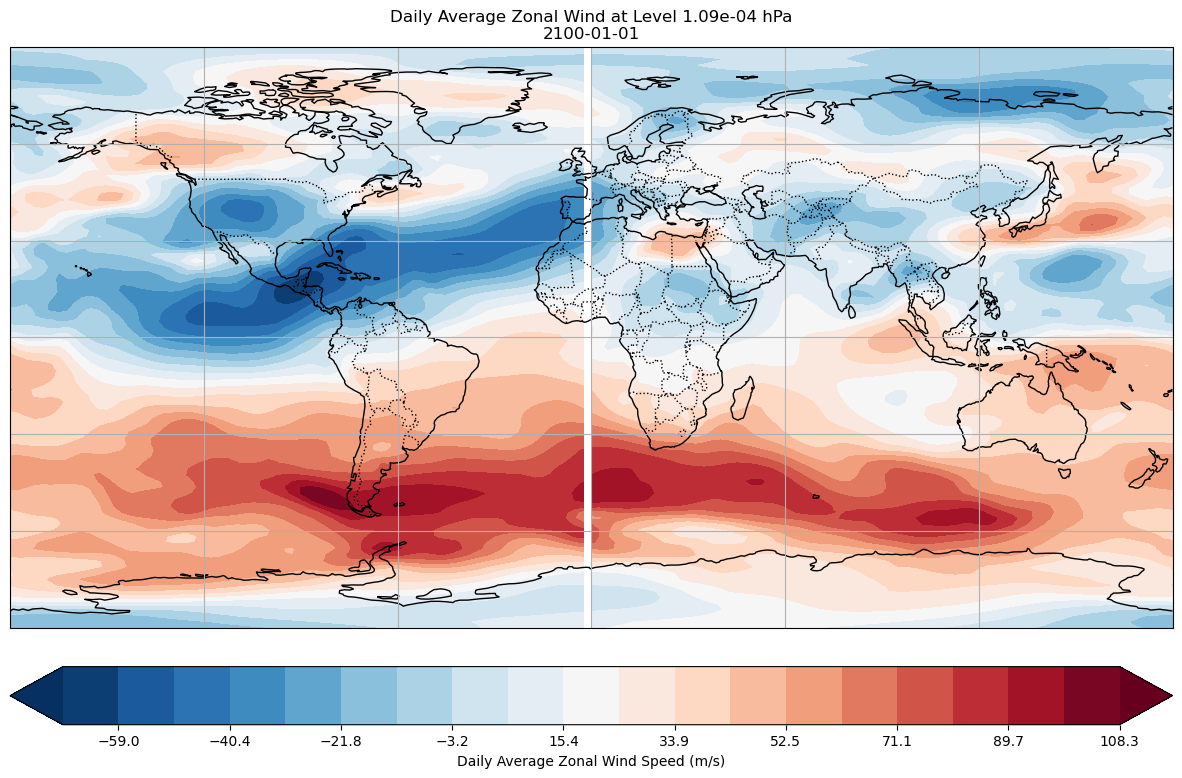

In [15]:
def plot_daily_average_zonal_wind(dataset, level_index=0):
    u_wind_avg = dataset.U.mean(dim='time')

    u_wind = u_wind_avg[level_index, :, :]

    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines()

    lons = dataset.lon.values
    lats = dataset.lat.values
    lon2d, lat2d = np.meshgrid(lons, lats)

    levels = np.linspace(u_wind.min(), u_wind.max(), 20)
    cf = ax.contourf(lon2d, lat2d, u_wind, 
                     transform=ccrs.PlateCarree(),
                     levels=levels,
                     cmap='RdBu_r',
                     extend='both')

    plt.colorbar(cf, ax=ax, orientation='horizontal', 
                label='Daily Average Zonal Wind Speed (m/s)',
                pad=0.05)
    
    # Add title
    pressure_level = dataset.lev[level_index].values
    date_str = str(dataset.time[0].values).split(' ')[0] 
    plt.title(f'Daily Average Zonal Wind at Level {pressure_level:.2e} hPa\n{date_str}')
    
    return fig

fig = plot_daily_average_zonal_wind(ds, level_index=50)
plt.show()

In [16]:
def plot_monthly_wind(base_path, month, level_index=0):

    file_pattern = base_path.format(month=month, day='*')

    print(f"Looking for files matching pattern: {file_pattern}")
    files = glob.glob(file_pattern)
    print(f"Found {len(files)} files")

    ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')

    u_wind_avg = ds.U.mean(dim='time')
    u_wind = u_wind_avg[level_index, :, :]

    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines()

    lons = ds.lon.values
    lats = ds.lat.values
    lon2d, lat2d = np.meshgrid(lons, lats)

    levels = np.linspace(u_wind.min(), u_wind.max(), 20)
    cf = ax.contourf(lon2d, lat2d, u_wind, 
                     transform=ccrs.PlateCarree(),
                     levels=levels,
                     cmap='RdBu_r',
                     extend='both')

    plt.colorbar(cf, ax=ax, orientation='horizontal', 
                label='Monthly Average Zonal Wind Speed (m/s)',
                pad=0.05)

    pressure_level = ds.lev[level_index].values
    month_name = {
        '01': 'January', '02': 'February', '03': 'March',
        '04': 'April', '05': 'May', '06': 'June',
        '07': 'July', '08': 'August', '09': 'September',
        '10': 'October', '11': 'November', '12': 'December'
    }[month]
    
    plt.title(f'Monthly Average Zonal Wind at Level {pressure_level:.2e} hPa\n{month_name} 2100')
    
    ds.close()
    
    return fig

Looking for files matching pattern: /resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-01-*-*.nc
Found 31 files


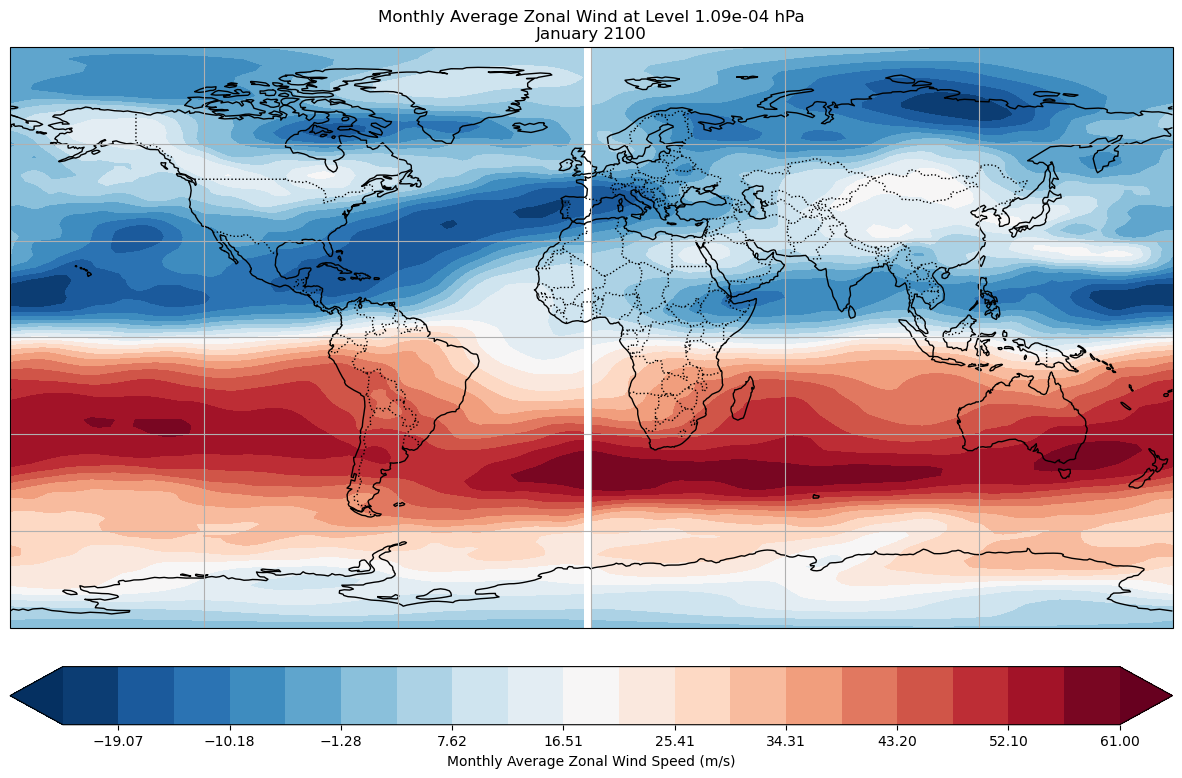

In [17]:
base_path = "/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
fig = plot_monthly_wind(base_path, month='01', level_index=50)
plt.show()

In [18]:
def plot_all_monthly_winds(base_path, level_index=0):

    fig = plt.figure(figsize=(20, 15))

    month_names = {
        '01': 'January', '02': 'February', '03': 'March',
        '04': 'April', '05': 'May', '06': 'June',
        '07': 'July', '08': 'August', '09': 'September',
        '10': 'October', '11': 'November', '12': 'December'
    }
    
    all_wind_data = []
    
    for month in [f"{i:02d}" for i in range(1, 13)]: # Creates the array [01, 02, 03, ...]
        file_pattern = base_path.format(month=month, day='*')
        files = glob.glob(file_pattern)
            
        ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
        u_wind_avg = ds.U.mean(dim='time')
        all_wind_data.append(u_wind_avg[level_index, :, :])
        ds.close()

    vmin = min(data.min() for data in all_wind_data)
    vmax = max(data.max() for data in all_wind_data)
    levels = np.linspace(vmin, vmax, 20) # Consistant colour bar
    
    for idx, (month, wind_data) in enumerate(zip([f"{i:02d}" for i in range(1, 13)], all_wind_data)):
        ax = fig.add_subplot(3, 4, idx + 1, projection=ccrs.PlateCarree())
        
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
        ax.gridlines(linewidth=0.5, alpha=0.5)

        if idx == 0: 
            lons = ds.lon.values
            lats = ds.lat.values
            pressure_level = ds.lev[level_index].values
        
        lon2d, lat2d = np.meshgrid(lons, lats)

        cf = ax.contourf(lon2d, lat2d, wind_data,
                        transform=ccrs.PlateCarree(),
                        levels=levels,
                        cmap='RdBu_r',
                        extend='both')

        ax.set_title(f'{month_names[month]}', fontsize=10)

    fig.suptitle(f'Monthly Average Zonal Wind at Level {pressure_level:.2e} hPa - 2100',
                 fontsize=14, y=0.95)
    
    cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
    cbar = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal',
                       label='Zonal Wind Speed (m/s)')
    
    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, hspace=0.3)
    
    return fig

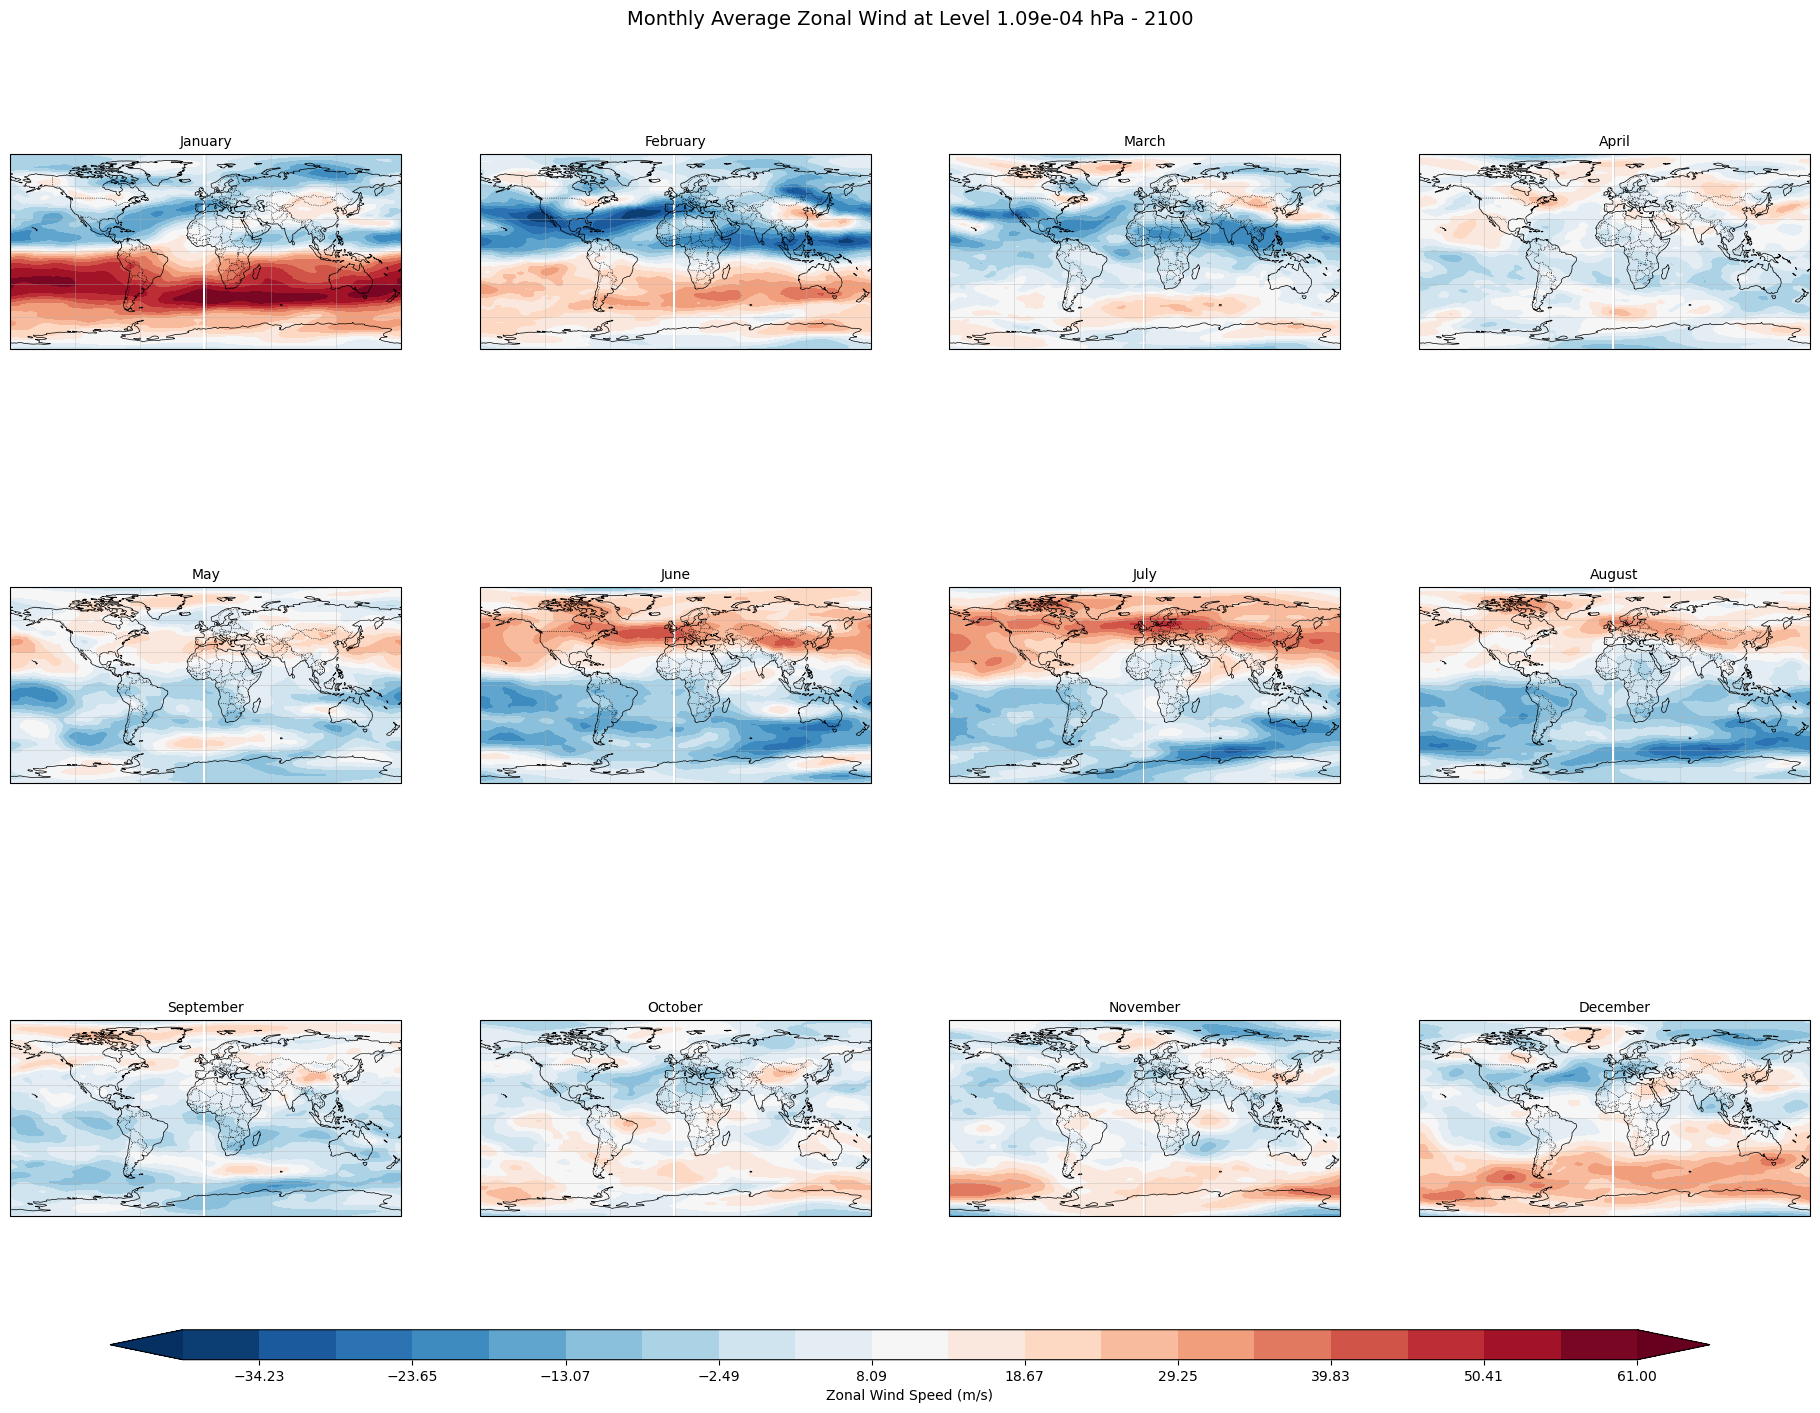

In [19]:
base_path = "/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
fig = plot_all_monthly_winds(base_path, level_index=50)
plt.show()